In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/30.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/29.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/28.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/32 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/31.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/32.jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/30 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/29 (2).jpg
/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/Moderate

In [6]:
import os
base_dir = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']


In [8]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [9]:
#Performing Image Augmentation to have more data samples
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6400, shuffle=False)

Found 6400 images belonging to 4 classes.


In [10]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [11]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [12]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [13]:
import imblearn
print(imblearn.__version__)

0.8.0


In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [16]:
#Splitting the data into train, test, and validation sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


In [17]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(176,176,3), 
                   include_top=False,
                   weights="imagenet")

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 44, 128)       0     

In [20]:
# Building Model

from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12800)             51200     
_________________________________________________________________
dense (Dense)                (None, 2048)              26216448  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [21]:
import tensorflow as tf
OPT    = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [23]:
import tensorflow as tf

tf.config.run_functions_eagerly(True)

In [24]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 5

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/5
256/256 [==============================] - 62s 223ms/step - loss: 1.1106 - auc: 0.8390 - val_loss: 0.4525 - val_auc: 0.9628
Epoch 2/5
256/256 [==============================] - 56s 220ms/step - loss: 0.5386 - auc: 0.9503 - val_loss: 0.3567 - val_auc: 0.9765
Epoch 3/5
256/256 [==============================] - 56s 219ms/step - loss: 0.4456 - auc: 0.9644 - val_loss: 0.3223 - val_auc: 0.9803
Epoch 4/5
256/256 [==============================] - 56s 219ms/step - loss: 0.3590 - auc: 0.9767 - val_loss: 0.2854 - val_auc: 0.9845
Epoch 5/5
256/256 [==============================] - 56s 219ms/step - loss: 0.3342 - auc: 0.9793 - val_loss: 0.2691 - val_auc: 0.9859


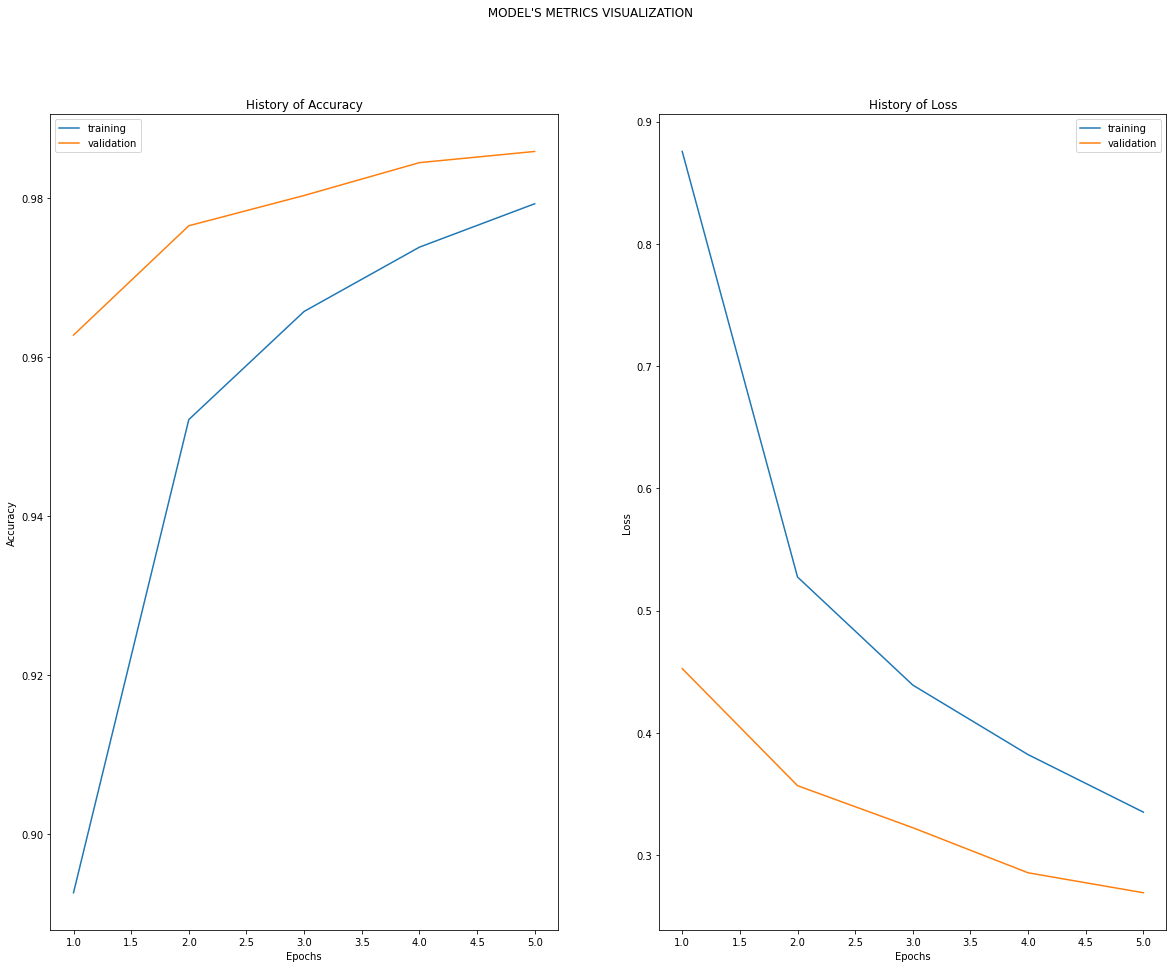

In [25]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,15))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['auc'],history.history['val_auc'],
               history.history['loss'],history.history['val_loss'])

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
pred_labels = model.predict(test_data)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

from sklearn.metrics import roc_auc_score
print("Accuracy is",roc_auc_score(test_labels, pred_labels))


[1. 0. 0. 0.]
                  precision    recall  f1-score   support

     NonDemented       0.91      0.96      0.94       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.83      0.83      0.83       662
ModerateDemented       0.84      0.80      0.82       624

       micro avg       0.90      0.90      0.90      2560
       macro avg       0.90      0.90      0.90      2560
    weighted avg       0.90      0.90      0.90      2560
     samples avg       0.90      0.90      0.90      2560

Accuracy is 0.931603716297268


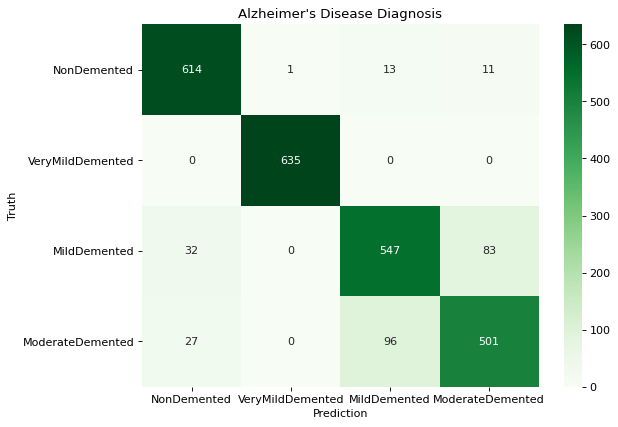

In [27]:
#Plot the confusion matrix to understand the classification in detail
import seaborn as sns
import matplotlib.pyplot as plt

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)